## FINOVIA BOT- YOUR EXPERT KNOWLEDGE WORKER!!!

### A question answering agent that is an expert knowledge worker
### To be used by employees of Finovia, a Finance Bank
### The agent needs to be accurate and the solution should be low cost.

This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

In [4]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [5]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain_community.embeddings import HuggingFaceEmbeddings

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_openai import ChatOpenAI

In [7]:
# Use a low cost model since cost is equally important

MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [8]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [9]:
# Read in documents using LangChain's loaders
# Load all the information from our knowledge-base folder

folders = glob.glob("knowledge-base-bank/*")

def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc
text_loader_kwargs = {'encoding': 'utf-8'}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")

Total number of chunks: 25
Document types found: {'company', 'employees', 'services', 'contracts'}


In [10]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

embeddings = OpenAIEmbeddings()
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 25 documents


In [11]:
# Let's investigate the vectors

collection = vectorstore._collection 
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 25 vectors with 1,536 dimensions in the vector store


## Visualizing the Vector Store

In [12]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['company', 'services', 'employees', 'contracts'].index(t)] for t in doc_types]

/Users/likhs/projects/llm_engineering/venv311/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


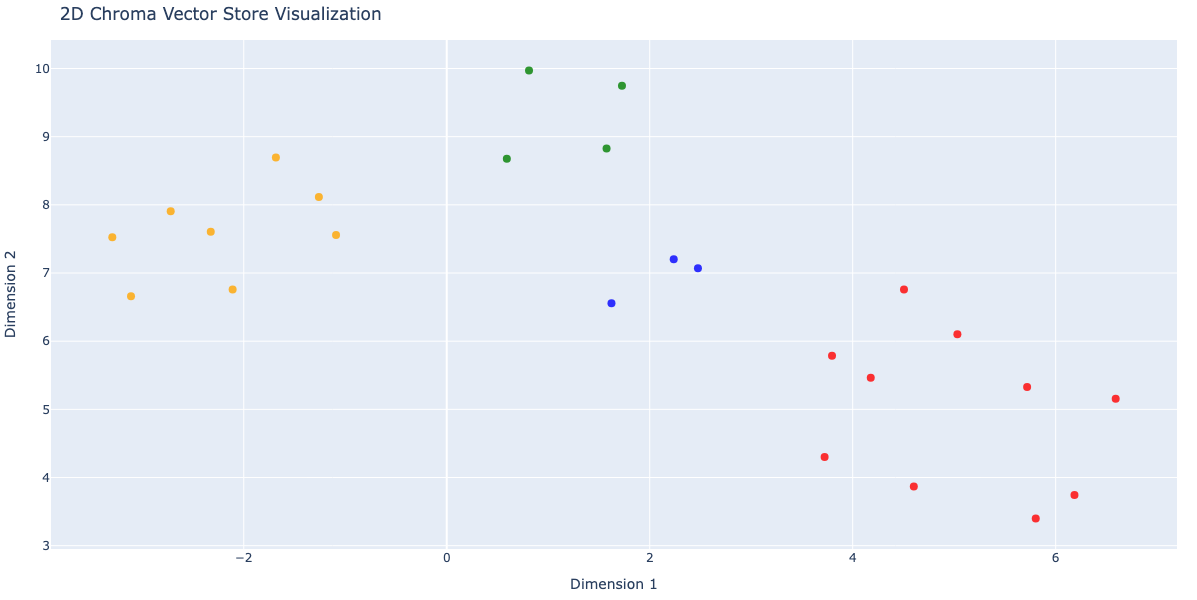

In [13]:
# Visualize a 2-D structure of your chroma vector datastore containing your documents using a tSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10) 
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=8, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    xaxis_title='Dimension 1',
    yaxis_title='Dimension 2',
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

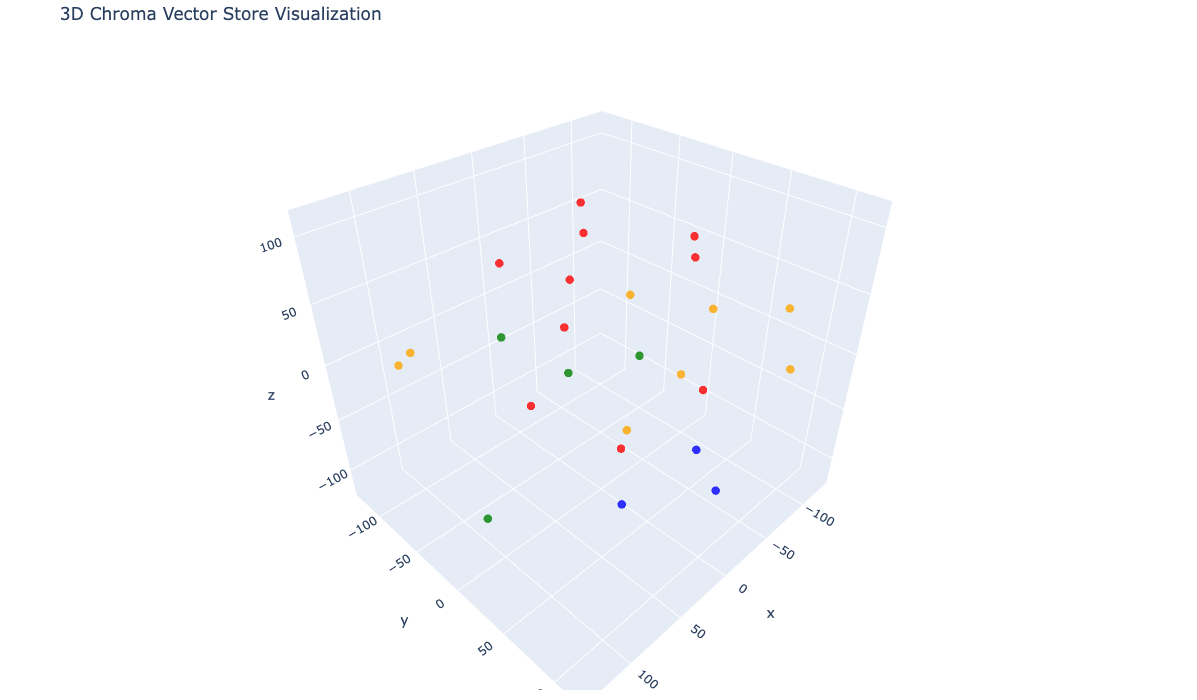

In [14]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42, perplexity=10)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [15]:
# Create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# Set up the retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

# Create the prompt template with memory
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant answering questions about a company. 
    Use the following context to answer the question. If you don't know the answer, say so.
    
    Context: {context}"""),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{question}")
])

In [17]:
from operator import itemgetter
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Answer the question based on the following context:\n\n{context}"),
    MessagesPlaceholder(variable_name="chat_history", optional=True),
    ("human", "{question}")
])

conversational_chain = (
    {
        "context": itemgetter("question") | retriever | format_docs,
        "question": itemgetter("question"),
        "chat_history": itemgetter("chat_history")
    }
    | prompt
    | llm
    | StrOutputParser()
)


In [18]:
# Let's try asking it a simple question
query = "Please talk about the ceo of your bank"
result = conversational_chain.invoke({
    "question": query,
    "chat_history": []  # Empty list for first question
})

print(f"\nAnswer: {result}")


Answer: The CEO of Finovia Bank is Laura Singh, who is also the founder of the institution. She has been leading the company since its inception in January 2012. Based in New York, Laura is known for her visionary approach in the fintech sector, driving innovation and strategic partnerships to propel the bank toward global expansion.

Under her leadership, Finovia Bank has established itself as a digital-first financial institution, focusing on customer banking that emphasizes innovation and transparency. Laura's commitment to democratizing access to modern banking has been instrumental in the bank's growth, which now serves over 8 million customers across 15 countries.

Laura's initiatives have led to the development of Finovia's flagship services, including DigitalBanking for online accounts, SmartLend for intelligent lending, SecureVault for data protection, and InvestIQ for smart investing. By 2025, Finovia is projected to employ over 1,000 people and operate 25 regional hubs worl

## Now we will bring this up in Gradio using the Chat interface -

A quick and easy way to prototype a chat with an LLM

In [19]:
from langchain_core.messages import HumanMessage, AIMessage

def chat(question, history):
    """Chat function for Gradio interface"""
    # Convert Gradio history to LangChain message format
    chat_history = []
    for msg in history:
        if msg["role"] == "user":
            chat_history.append(HumanMessage(content=msg["content"]))
        else:
            chat_history.append(AIMessage(content=msg["content"]))
    
    # Invoke chain with proper format
    result = conversational_chain.invoke({
        "question": question,
        "chat_history": chat_history
    })
    return result

In [20]:
# Create and launch Gradio interface
view = gr.ChatInterface(
    chat, 
    type="messages",
    title="Finovia's Expert Knowledge Worker",
    description="Ask questions about the bank!"
).launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
